# CosmoPowerJAX: differentiable emulators of cosmological power spectra

In this short walkthrough notebook, we are going to show how to use CosmoPower-JAX (CPJ), a set of neural emulators for the matter power spectrum and CMB probes.

Firstly, we make the usual imports and load a subset of the test dataset used to validate CPJ.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cosmopower_jax.cosmopower_jax import CosmoPowerJAX as CPJ

In [2]:
# Download data - for this you need to have gdown installed, i.e.
# pip install gdown
# This is only to have data to compare against, and it is not needed to use CPJ
!mkdir -p dataset
!gdown 1FERzMIinJjIPvITKFv6wzjZgm5Y5VeFv -O ./dataset/camb_tt_testing_params.npz
!gdown 16MSqQOxKqqmH37fV2e2vsVGx1rJO5YuQ -O ./dataset/camb_tt_testing_log_spectra.npz
!gdown 1tuljeR8TOpW_UF74g7ZVVNXCSXXwBhwW -O ./dataset/camb_pp_testing_params.npz
!gdown 1fHuqBsIypBIY_dwpkWL2KqAoF6WLc6aW -O ./dataset/camb_pp_testing_log_spectra.npz
!gdown 13bhZqNozxzoESsevH32noHBFuyrqaGIw -O ./dataset/mpk_lin_testing_params.npy
!gdown 12aFGoMH47XRBgeuQUu7eIiH-5XI4Vor1 -O ./dataset/mpk_lin_testing_log_spectra.npy
!gdown 1L5v41bmZ-_aBt24XMgoPakJzqy-NTF1C -O ./dataset/mpk_nlboost_testing_params.npy 
!gdown 1-AfhAh0IThpdGNj13Kk7M3LiSDJvnUul -O ./dataset/mpk_nlboost_testing_log_spectra.npy

Downloading...
From: https://drive.google.com/uc?id=1FERzMIinJjIPvITKFv6wzjZgm5Y5VeFv
To: /home/users/p/piras/jax_nofr/cosmopower-jax/notebooks/dataset/camb_tt_testing_params.npz
100%|████████████████████████████████████████| 459k/459k [00:00<00:00, 25.5MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=16MSqQOxKqqmH37fV2e2vsVGx1rJO5YuQ
From (redirected): https://drive.google.com/uc?id=16MSqQOxKqqmH37fV2e2vsVGx1rJO5YuQ&confirm=t&uuid=0ec79bf0-9df9-44c5-af67-f7d71b4c1ffa
To: /home/users/p/piras/jax_nofr/cosmopower-jax/notebooks/dataset/camb_tt_testing_log_spectra.npz
100%|█████████████████████████████████████████| 191M/191M [00:01<00:00, 113MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tuljeR8TOpW_UF74g7ZVVNXCSXXwBhwW
To: /home/users/p/piras/jax_nofr/cosmopower-jax/notebooks/dataset/camb_pp_testing_params.npz
100%|████████████████████████████████████████| 459k/459k [00:00<00:00, 19.0MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1fHuq

## CMB temperature power spectrum

In [3]:
# We extract a numpy array with the cosmological parameters
# In general this can be any input array that you prefer, in the order:
# omega_b, omega_cdm, h, tau, n_s, ln10^{10}A_s
cosmo_params = []
cosmo_params_dict = np.load('./dataset/camb_tt_testing_params.npz')
for item in cosmo_params_dict.items():
    cosmo_params.append(item[1]) # extract the actual parameters from the dictionary
cosmo_params = np.array(cosmo_params).T

# We also extract the actual spectra from CAMB
testing_spectra = np.load('./dataset/camb_tt_testing_log_spectra.npz')['features']
# we exponentiate, since these are log-spectra 
testing_spectra = 10**testing_spectra

After loading the parameters that we want to use as input, using CosmoPower-JAX to predict the TT CMB power spectrum is as easy as follows.

In [4]:
emulator = CPJ(probe='cmb_tt')
emulator_predictions = emulator.predict(cosmo_params)
# you might get a warning if you do not have a GPU - not a problem!

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
emulator_predictions.shape

(9531, 2507)

Note that we could also get the same predictions by passing a dictionary, to maintain the same syntax as in the original CP. In that case, you can do something like:
```
params = {'omega_b': cosmo_params_dict['omega_b'],
          'omega_cdm': cosmo_params_dict['omega_cdm'],
          'h': cosmo_params_dict['h'],
          'tau_reio': cosmo_params_dict['tau_reio'],
          'n_s': cosmo_params_dict['n_s'],
          'ln10^{10}A_s': cosmo_params_dict['ln10^{10}A_s'],
          }
emulator = CPJ(probe='cmb_tt')
emulator_predictions = emulator.predict(params)
```

Note that we predicted almost 10k spectra in about a second on CPU - not bad!

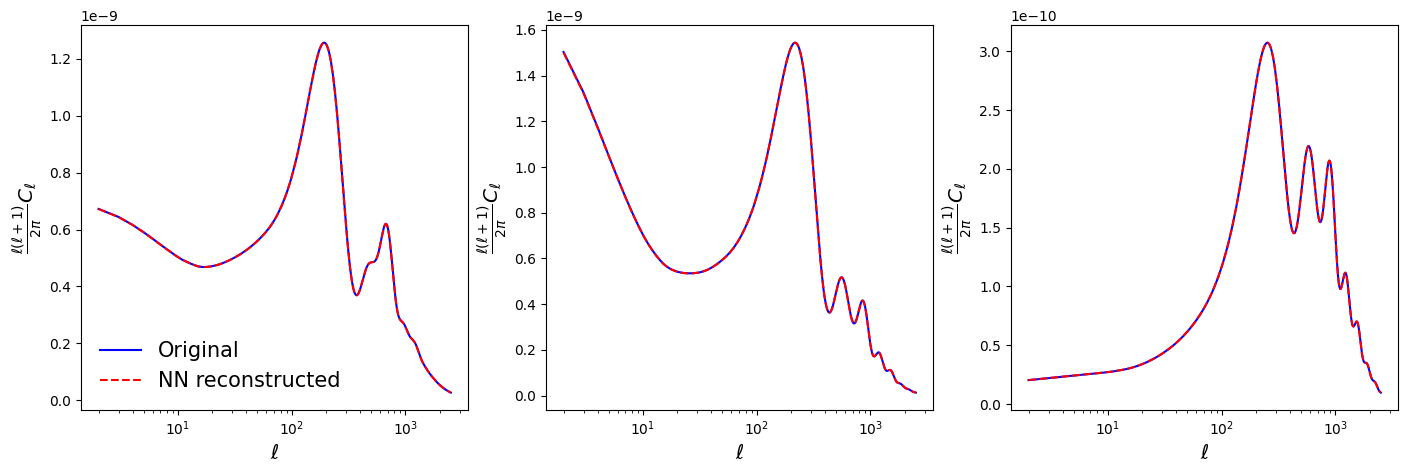

In [6]:
# and now we can compare to the actual CAMB predictions, on three random samples
ell_range = emulator.modes
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(17,5))
for i in range(3):
    pred = emulator_predictions[i]*ell_range*(ell_range+1)/(2.*np.pi)
    true = testing_spectra[i]*ell_range*(ell_range+1)/(2.*np.pi)
    ax[i].semilogx(ell_range, true, 'blue', label = 'Original')
    ax[i].semilogx(ell_range, pred, 'red', label = 'NN reconstructed', linestyle='--')
    ax[i].set_xlabel('$\ell$', fontsize='x-large')
    ax[i].set_ylabel('$\\frac{\ell(\ell+1)}{2 \pi} C_\ell$', fontsize='x-large')
    if i == 0:
        ax[i].legend(fontsize=15, frameon=False)

We can also compute the derivatives of the TT power spectrum with respect to any input cosmological parameter.

In [7]:
# we limit the number of derivatives we compute at once, only to avoid memory problems
emulator_derivatives = emulator.derivative(cosmo_params[:10])
emulator_derivatives.shape

(2507, 6, 10)

Note the shape of the resulting array: for each $\ell$ mode, we have the derivative with respect to each parameter (out of 6), and for a batch of input vectors (where the derivative is evaluated). We can also plot this as follows: for a single input set of cosmological parameters, we plot the derivatives with respect to each cosmological parameter. 

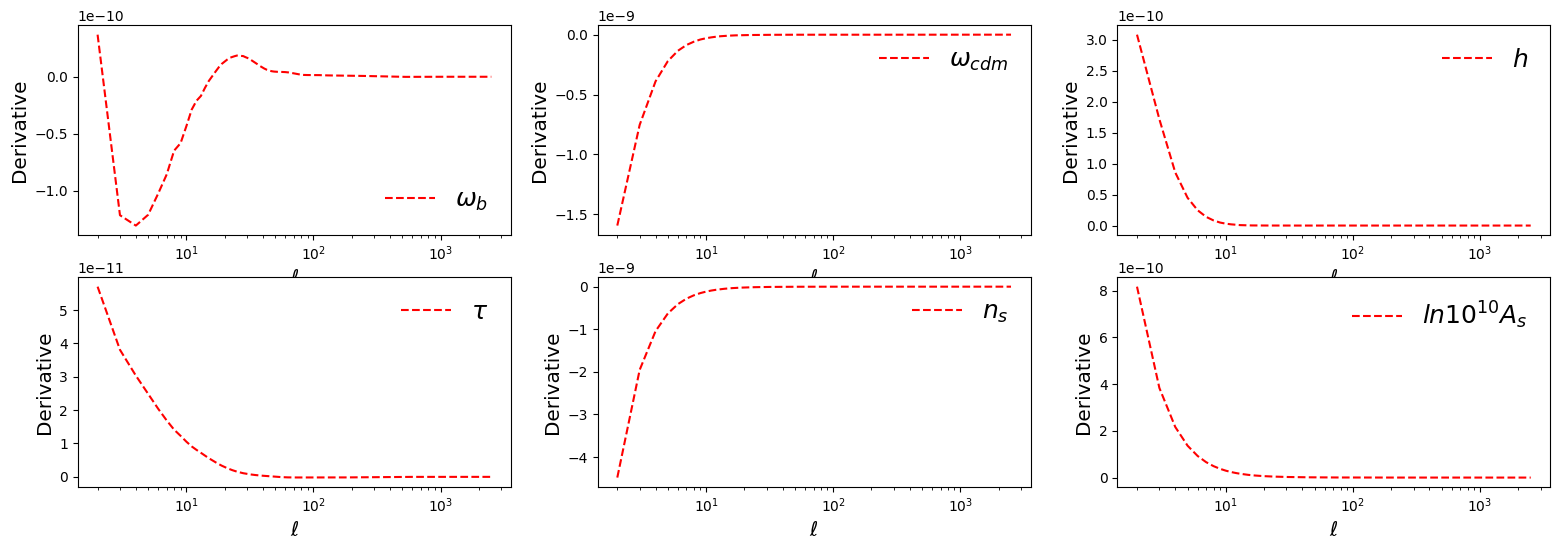

In [8]:
parameters = ['$\omega_b$', '$\omega_{cdm}$', '$h$', r'$\tau$', '$n_s$', '$ln10^{10}A_s$']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(19,6))
for i, ax in enumerate(axes.flatten()):
    pred = emulator_derivatives[:, i, 8]
    ax.semilogx(ell_range, pred, 'red', label = parameters[i], linestyle='--')
    ax.set_xlabel('$\ell$', fontsize='x-large')
    ax.set_ylabel('Derivative', fontsize='x-large')
    ax.legend(fontsize=18, frameon=False)

A comparison with respect to finite differences with e.g. a [five-point stencil](https://en.wikipedia.org/wiki/Five-point_stencil) using CAMB can be found in the [CosmoPower-JAX release paper](https://arxiv.org/abs/2305.06347v1).

## CMB lensing potential power spectrum

We can repeat the same for e.g. the lensing potential power spectrum. Under the hood, the prediction also uses the PCA matrix involved in the preprocessing of the training data to return the power spectrum. You do not need to worry about this, though.

In [9]:
# Again, in general this can be any input array that you prefer, in the order:
# omega_b, omega_cdm, h, tau, n_s, ln10^{10}A_s
cosmo_params = []
cosmo_params_dict = np.load('./dataset/camb_pp_testing_params.npz')
for item in cosmo_params_dict.items():
    cosmo_params.append(item[1]) # extract the actual parameters from the dictionary
cosmo_params = np.array(cosmo_params).T

# We also extract the actual spectra from CAMB
testing_spectra = np.load('./dataset/camb_pp_testing_log_spectra.npz')['features']
# we exponentiate, since these are log-spectra 
testing_spectra = 10**testing_spectra

In [10]:
# again, simply predict
emulator = CPJ(probe='cmb_pp')
emulator_predictions = emulator.predict(cosmo_params)

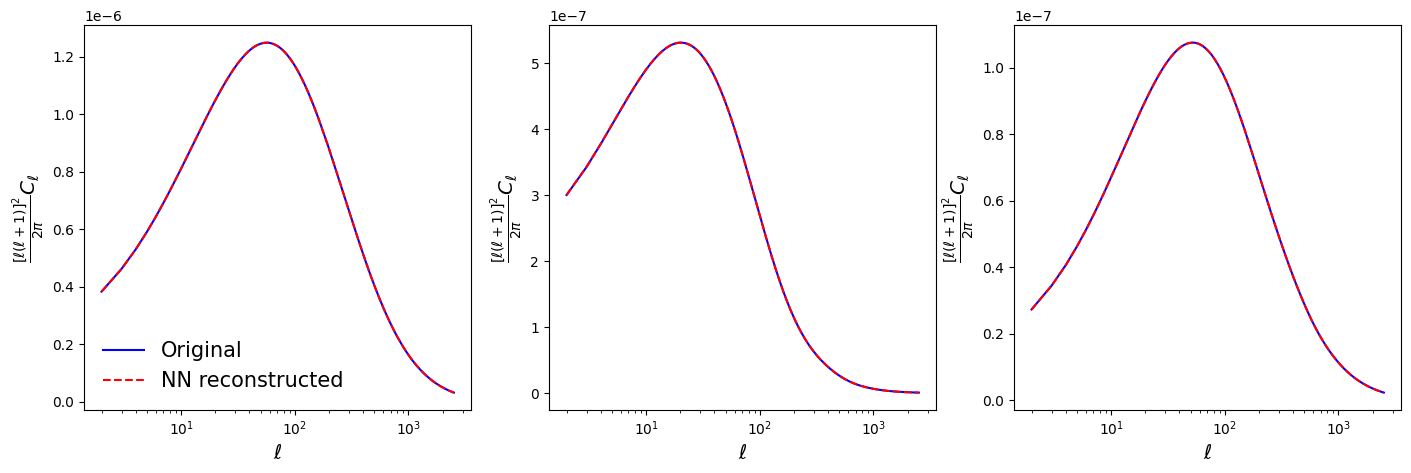

In [11]:
# and compare
ell_range = emulator.modes
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(17,5))
for i in range(3):
    pred = emulator_predictions[i]*ell_range*ell_range*(ell_range+1)*(ell_range+1)/(2.*np.pi)
    true = testing_spectra[i]*ell_range*ell_range*(ell_range+1)*(ell_range+1)/(2.*np.pi)
    ax[i].semilogx(ell_range, true, 'blue', label = 'Original')
    ax[i].semilogx(ell_range, pred, 'red', label = 'NN reconstructed', linestyle='--')
    ax[i].set_xlabel('$\ell$', fontsize='x-large')
    ax[i].set_ylabel('$\\frac{[\ell(\ell+1)]^2}{2 \pi} C_\ell$', fontsize='x-large')
    if i == 0:
        ax[i].legend(fontsize=15, frameon=False)

We can again compute derivatives straightforwardly, even through PCA.

In [12]:
# we limit the number of derivatives we compute at once, only to avoid memory problems
emulator_derivatives = emulator.derivative(cosmo_params[:10])
emulator_derivatives.shape

(2507, 6, 10)

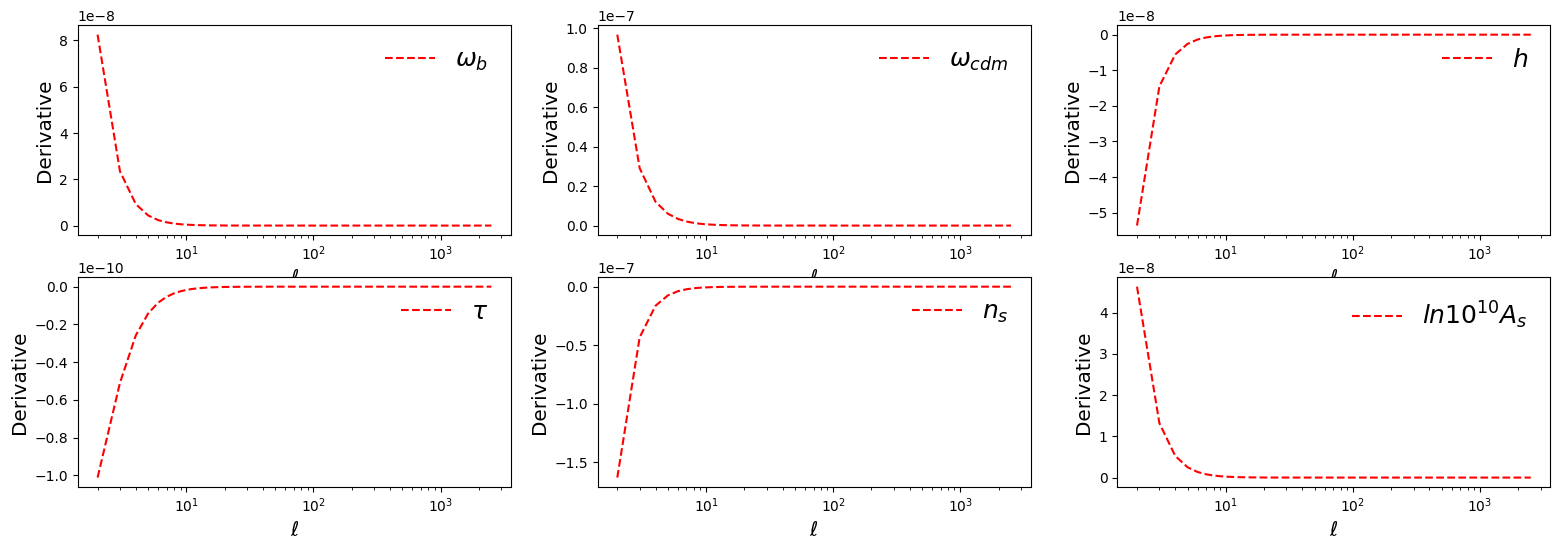

In [13]:
parameters = ['$\omega_b$', '$\omega_{cdm}$', '$h$', r'$\tau$', '$n_s$', '$ln10^{10}A_s$']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(19,6))
for i, ax in enumerate(axes.flatten()):
    pred = emulator_derivatives[:, i, 8]
    ax.semilogx(ell_range, pred, 'red', label = parameters[i], linestyle='--')
    ax.set_xlabel('$\ell$', fontsize='x-large')
    ax.set_ylabel('Derivative', fontsize='x-large')
    ax.legend(fontsize=18, frameon=False)

## Matter power spectrum

We first compare the linear matter power spectrum predictions.

In [14]:
# Loading the input data, and the ground truth to make a comparison.
# In this case, the parameters are (in brackets the non-linear ones):
# omega_b, omega_cdm, h, n_s, ln10^{10}A_s, (c_min, eta0), z 
cosmo_params = np.load('./dataset/mpk_lin_testing_params.npy')

# We also extract the actual spectra from CAMB
testing_spectra = np.load('./dataset/mpk_lin_testing_log_spectra.npy')
# we exponentiate, since these are log-spectra 
testing_spectra = 10**testing_spectra

In [15]:
cosmo_params.shape

(10000, 6)

In [16]:
# again, simply predict
emulator = CPJ(probe='mpk_lin')
emulator_predictions = emulator.predict(cosmo_params)

In this case, to pass a dictionary you could do:
```
params = {'omega_b': cosmo_params[:, 0],
          'omega_cdm': cosmo_params[:, 1],
          'h': cosmo_params[:, 2],
          'n_s': cosmo_params[:, 3],
          'ln10^{10}A_s':cosmo_params[:, 4],
          'z': cosmo_params[:, 5],
          }
emulator = CPJ(probe='mpk_lin')
emulator_predictions = emulator.predict(params)
```

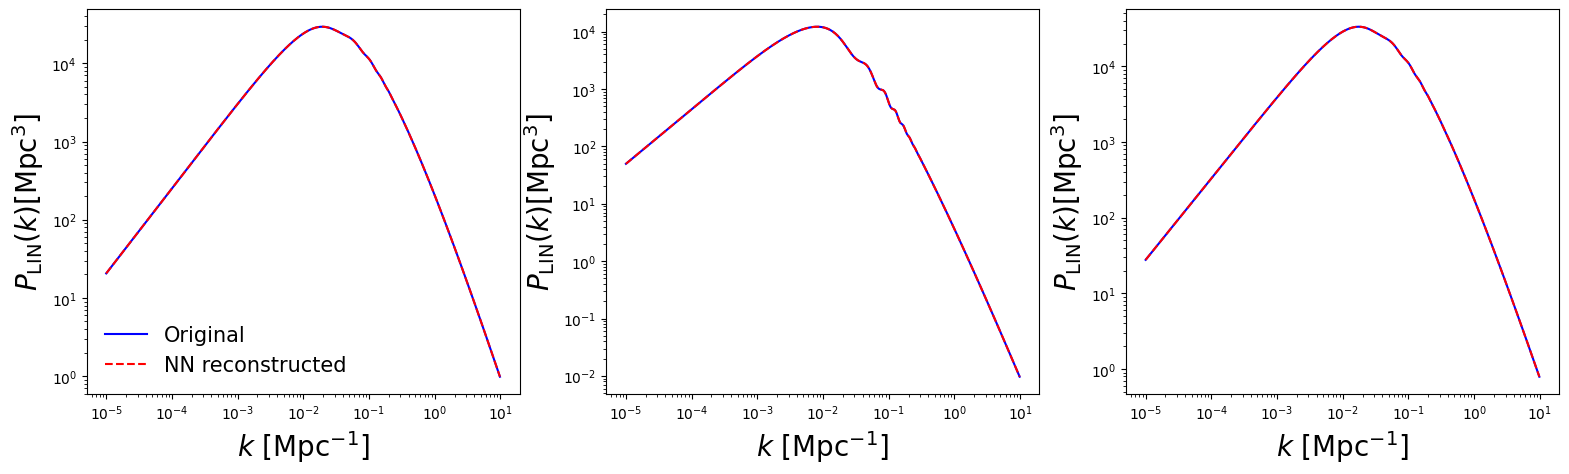

In [17]:
# and compare
k_range = emulator.modes
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(19,5))
for i in range(3):
    pred = emulator_predictions[i]
    true = testing_spectra[i]
    ax[i].loglog(k_range, true, 'blue', label = 'Original')
    ax[i].loglog(k_range, pred, 'red', label = 'NN reconstructed', linestyle='--')
    ax[i].set_xlabel('$k$ [Mpc$^{-1}]$', fontsize=20)
    ax[i].set_ylabel('$P_{\mathrm{LIN}}(k) [\mathrm{Mpc}^3]$', fontsize=20)
    if i == 0:
        ax[i].legend(fontsize=15, frameon=False)

In [18]:
# again, we can compute the derivative too
emulator_derivatives = emulator.derivative(cosmo_params[:10])
emulator_derivatives.shape

(420, 6, 10)

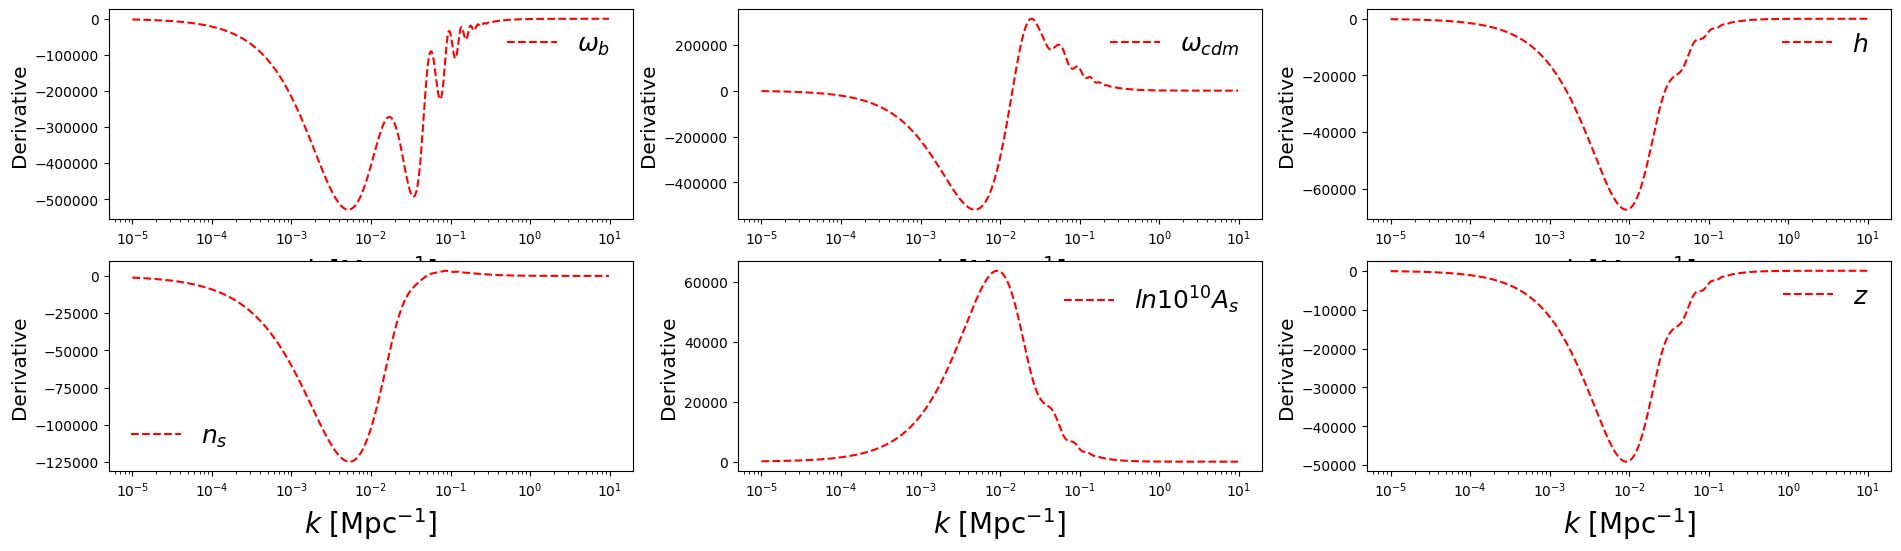

In [19]:
parameters = ['$\omega_b$', '$\omega_{cdm}$', '$h$', '$n_s$', '$ln10^{10}A_s$', '$z$']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(23,6))
for i, ax in enumerate(axes.flatten()):
    pred = emulator_derivatives[:, i, 8]
    ax.semilogx(k_range, pred, 'red', label = parameters[i], linestyle='--')
    ax.set_xlabel('$k$ [Mpc$^{-1}]$', fontsize=20)
    ax.set_ylabel('Derivative', fontsize='x-large')
    ax.legend(fontsize=18, frameon=False)

### Non-linear matter power spectrum

To predict the non-linear power spectrum, note that you would in principle need to pay attention to the fact that the linear emulator requires 6 parameters as input, while the non-linear boost one 8 in total. CPJ takes care of it, so you can simply do as follows.

In [20]:
# this has 8 parameters
cosmo_params = np.load('./dataset/mpk_nlboost_testing_params.npy')

In [21]:
# predict the non-linear matter power spectrum
emulator = CPJ(probe='mpk_nonlin')
emulator_predictions = emulator.predict(cosmo_params)

With the dictionary, in this case it would be like:
```
params = {'omega_b': cosmo_params[:, 0],
          'omega_cdm': cosmo_params[:, 1],
          'h': cosmo_params[:, 2],
          'n_s': cosmo_params[:, 3],
          'ln10^{10}A_s':cosmo_params[:, 4],
          'cmin': cosmo_params[:, 5],
          'eta_0': cosmo_params[:, 6],
          'z': cosmo_params[:, 7],
          }
emulator = CPJ(probe='mpk_nonlin')
emulator_predictions_ = emulator.predict(params)
```

In [22]:
# To compare to CAMB, we combine the linear power and boost from the pre-saved files
testing_spectra_nlboost = np.load('./dataset/mpk_nlboost_testing_log_spectra.npy')
# we exponentiate, since these are log-spectra, and multiply by the linear spectra
testing_spectra_nonlin = 10**testing_spectra_nlboost * testing_spectra

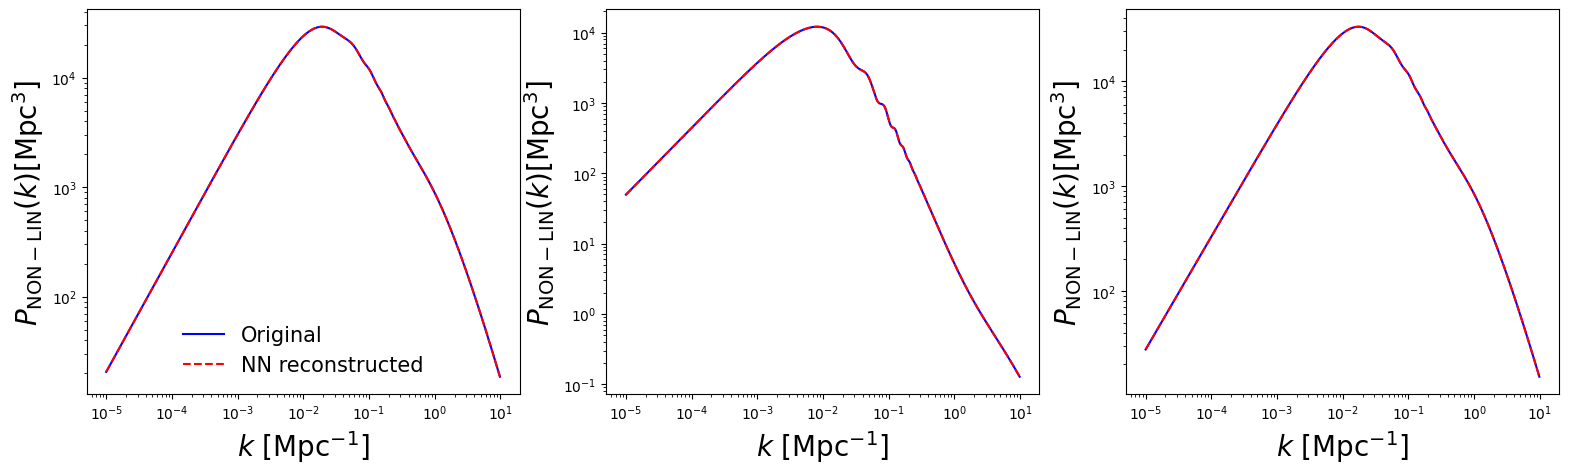

In [23]:
# and finally plot
k_range = emulator.modes
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(19,5))
for i in range(3):
    pred = emulator_predictions[i]
    true = testing_spectra_nonlin[i]
    ax[i].loglog(k_range, true, 'blue', label = 'Original')
    ax[i].loglog(k_range, pred, 'red', label = 'NN reconstructed', linestyle='--')
    ax[i].set_xlabel('$k$ [Mpc$^{-1}]$', fontsize=20)
    ax[i].set_ylabel('$P_{\mathrm{NON-LIN}}(k) [\mathrm{Mpc}^3]$', fontsize=20)
    if i == 0:
        ax[i].legend(fontsize=15, frameon=False)

In [24]:
# again, we can compute the derivatives too
emulator_derivatives = emulator.derivative(cosmo_params[:10])
emulator_derivatives.shape

(420, 8, 10)

## Using a custom `.pkl` file

You might have a model trained with the original CosmoPower (CP) version, that you wish to now use in a JAX framework. Assuming the model has exactly the same form as the original CP version, you can use them in JAX by following these steps.

First, you'll need to:

```
   git clone https://github.com/dpiras/cosmopower-jax.git
   cd cosmopower-jax
```

and move your model(s) `.pkl` files into the folder `cosmopower_jax/trained_models`. At this point:

- if you can call your models from the `cosmopower-jax` folder you are in, you should be good to go;
- otherwise, run first `pip install .`, and then you should be able to call your custom models from anywhere.
 
To call a custom model, you can run:

```
from cosmopower_jax.cosmopower_jax import CosmoPowerJAX as CPJ
emulator_custom = CPJ(probe='custom_log', filename='<custom_filename>.pkl')
```

where `<custom_filename>.pkl` is the filename (only, no path) with your custom model, and `custom_log` indicates that your model was trained on log-spectra, so all predictions will be returned raised to the power of 10. Alternatively, you can pass `custom_pca`, and you will automatically get the predictions for a model trained with `PCAplusNN`.

Finally, note that since old CP models were trained with `tensorflow`, you might also have to `pip install tensorflow` to run your custom models.

This notebook shows the basic usage of CosmoPower-JAX. If you would like to have more features available, like training your own models, feel free to [raise an issue](https://github.com/dpiras/cosmopower-jax/issues) or contact [Davide Piras](mailto:davide.piras@unige.ch).